# Curate dataset (unfiltered_dataset.csv)

### Imports

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Get the raw dataset

In [12]:
df = pd.read_csv("unfiltered_dataset_v2.csv")
# Fixing columns
df.drop('Imin', axis=1, inplace=True) # Not used
df['G_spec_int'] = df['G_spec_int']*1.234 # Spectral irradiance up to 4000 nm

C:\Users\syaba\AppData\Local\Temp\ipykernel_20176\2322018833.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("unfiltered_dataset_v2.csv")


# Data Curating

Drop duplicates

In [13]:
initial_len = df.shape[0]
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
final_len = df.shape[0]
print(f"Original rows: {initial_len}.\nUnique rows: {final_len}.\nDropped {initial_len - final_len} samples.")


Original rows: 1735212.
Unique rows: 1708501.
Dropped 26711 samples.


Timestamp as datetime object

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by='timestamp', inplace=True)

In [15]:
df.columns

Index(['filename', 'module_name', 'timestamp', 'Vmpp', 'Impp', 'Pmpp',
       'G_spec_int', 'G_tilt20_start', 'G_tilt15_start', 'G_horiz_start',
       'G_east_start', 'G_west_start', 'G_refl_start', 'G_horiz_end',
       'G_tilt20_end', 'G_tilt15_end', 'G_east_end', 'G_west_end',
       'G_refl_end', 'module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure',
       'wind_speed_ms', 'wind_direction', 'Isc', 'R2_Isc', 'Rsh', 'Voc',
       'R2_Voc', 'Rs', 'FF', 'V_ini', 'I_ini'],
      dtype='object')

## Physics-based filtering

In [16]:
def clean_by_physics(df):
    clean_df = df.copy()
    numeric_columns = clean_df.columns.drop(['filename', 'module_name', 'timestamp'])
    clean_df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # 1. Temperature: Terrestrial limits 
    temp_cols = ['air_temperature', 'module_temperature_center', 'module_temperature_lateral']
    for col in temp_cols:
        clean_df.loc[(clean_df[col] < -50) | (clean_df[col] > 100), col] = np.nan
        
    # 2. Irradiance (G_ columns): Cannot be negative or exceed solar constant
    g_cols = [c for c in clean_df.columns if c.startswith('G_')]
    for col in g_cols:
        clean_df.loc[(clean_df[col] < 0) | (clean_df[col] > 2000), col] = np.nan
        
    # 3. Humidity: Must be a percentage
    clean_df.loc[(clean_df['relative_humidity'] < 0) | (clean_df['relative_humidity'] > 100), 'relative_humidity'] = np.nan
    
    # 4. Wind Direction: 0 to 360 degrees
    clean_df.loc[(clean_df['wind_direction'] < 0) | (clean_df['wind_direction'] > 360), 'wind_direction'] = np.nan
    
    # 5. Air Density
    clean_df.loc[(clean_df['air_density'] < 0.5) | (clean_df['air_density'] > 2), 'air_density'] = np.nan
    
    # 6. Absolute pressure
    clean_df.loc[(clean_df['abs_pressure'] < 800), 'abs_pressure'] = np.nan

    # 7. Electrical parameters
    clean_df.loc[clean_df['Isc'] < 0, 'Isc'] = np.nan
    clean_df.loc[clean_df['Voc'] < 0, 'Voc'] = np.nan
    # Negative Impp or Vmpp -> Invalid Pmpp
    clean_df.loc[clean_df['Impp'] < 0, ['Impp', 'Pmpp']] = np.nan
    clean_df.loc[clean_df['Vmpp'] < 0, ['Vmpp', 'Pmpp']] = np.nan    

    # Fill factor must be between 0 and 1
    clean_df.loc[(clean_df['FF'] <= 0) | (clean_df['FF'] >= 1.0), 'FF'] = np.nan
    
    # Series and shunt resistances must be positive
    clean_df.loc[clean_df['Rsh'] <= 0, 'Rsh'] = np.nan
    clean_df.loc[clean_df['Rs'] <= 0, 'Rs'] = np.nan

    # Regression failed
    clean_df.loc[clean_df['R2_Isc'] < 0, 'Isc'] = np.nan
    clean_df.loc[clean_df['R2_Voc'] < 0, 'Voc'] = np.nan


   # 1. Establish the "Current Ceiling"
    # We take the maximum between our regressed Isc and our raw I_ini 
    i_ceiling = clean_df[['Isc', 'I_ini']].max(axis=1)

    # 2. Handle Impp < i_ceiling 
    # We allow a 5% margin for sensor noise/quantization.
    mask_impp_invalid = (clean_df['Impp'] > (i_ceiling * 1.05))
    clean_df.loc[mask_impp_invalid & i_ceiling.notna(), ['Impp', 'Pmpp']] = np.nan

    # 3. Repeat logic for Vmpp vs Voc (measured vs extrap)
    # Vmpp should never exceed the extrapolated Voc
    mask_vmpp_invalid = (clean_df['Vmpp'] > (clean_df['Voc'] * 1.05))
    clean_df.loc[mask_vmpp_invalid & clean_df['Voc'].notna(), ['Vmpp', 'Pmpp']] = np.nan
    
    # Power cannot be negative
    clean_df.loc[clean_df['Pmpp'] < 0, 'Pmpp'] = np.nan

    return clean_df

df_physics = clean_by_physics(df)

In [17]:
def summarize_cleaning(df_before, df_after):
    # List before and after cleaning per column
    before_counts = df_before.count()
    after_counts = df_after.count()

    # 2. Create the summary DataFrame
    stats_df = pd.DataFrame({
        'Before': before_counts,
        'After': after_counts,
        'Removed': before_counts - after_counts
    })

    # 3. Add a percentage column 
    stats_df['% Removed'] = ((stats_df['Removed'] / stats_df['Before']) * 100).round(2)

    # Display the results
    print(stats_df[stats_df['Removed'] > 0].sort_values('Removed', ascending=False))
    print(f"Summary: {before_counts.sum() - after_counts.sum()} datapoints removed. {(before_counts.sum() - after_counts.sum())/before_counts.sum()*100:.2f}% of total data.")

In [18]:
summarize_cleaning(df, df_physics)

                             Before    After  Removed  % Removed
module_temperature_lateral  1708501  1548727   159774       9.35
G_spec_int                  1616184  1537528    78656       4.87
Pmpp                        1708501  1703002     5499       0.32
Impp                        1708501  1703645     4856       0.28
module_temperature_center   1708501  1704222     4279       0.25
abs_pressure                1708501  1704418     4083       0.24
FF                          1708094  1705410     2684       0.16
air_density                 1708501  1706849     1652       0.10
Vmpp                        1708501  1706930     1571       0.09
Isc                         1705688  1705045      643       0.04
G_horiz_start               1708501  1708157      344       0.02
Voc                         1708282  1708022      260       0.02
G_tilt20_start              1708501  1708489       12       0.00
air_temperature             1708501  1708489       12       0.00
relative_humidity        

## Analyze ambient data

In [19]:
elec_cols = ['Vmpp', 'Impp', 'Pmpp', 'Voc', 'Isc']
df_ambient = df_physics.drop(columns=['filename', 'module_name', 'timestamp'] + elec_cols)
df_ambient.describe().T

,count,mean,std,min,25%,50%,75%,max
G_spec_int,1537528.0,388.428573,301.813948,0.000000e+00,134.900467,303.904464,604.913841,1.529526e+03
G_tilt20_start,1708489.0,401.489337,302.665252,1.101000e+01,143.050000,312.120000,630.260000,1.982440e+03
G_tilt15_start,1439431.0,390.135638,300.741735,0.000000e+00,134.540000,300.990000,611.360000,1.460320e+03
G_horiz_start,1708157.0,421.089487,315.169772,3.580000e+00,153.580000,331.060000,654.490000,1.999560e+03
G_east_start,1708501.0,187.751182,180.517401,2.200000e-01,67.090000,128.570000,229.320000,1.402550e+03
G_west_start,1708501.0,228.352014,214.841391,3.700000e-01,74.190000,148.610000,309.190000,1.502250e+03
G_refl_start,1708500.0,42.269152,30.334342,0.000000e+00,15.420000,36.540000,64.290000,7.409400e+02
G_horiz_end,1708500.0,409.146127,310.231024,1.310000e+00,145.330000,320.720000,640.440000,1.544920e+03
G_tilt20_end,1708501.0,394.751780,302.399732,2.900000e-01,136.480000,305.360000,623.550000,1.450160e+03
G_tilt15_end,1439434.0,390.244051,300.722052,2.000000e-02,134.630000,301.090000,611.570000,1.444120e+03


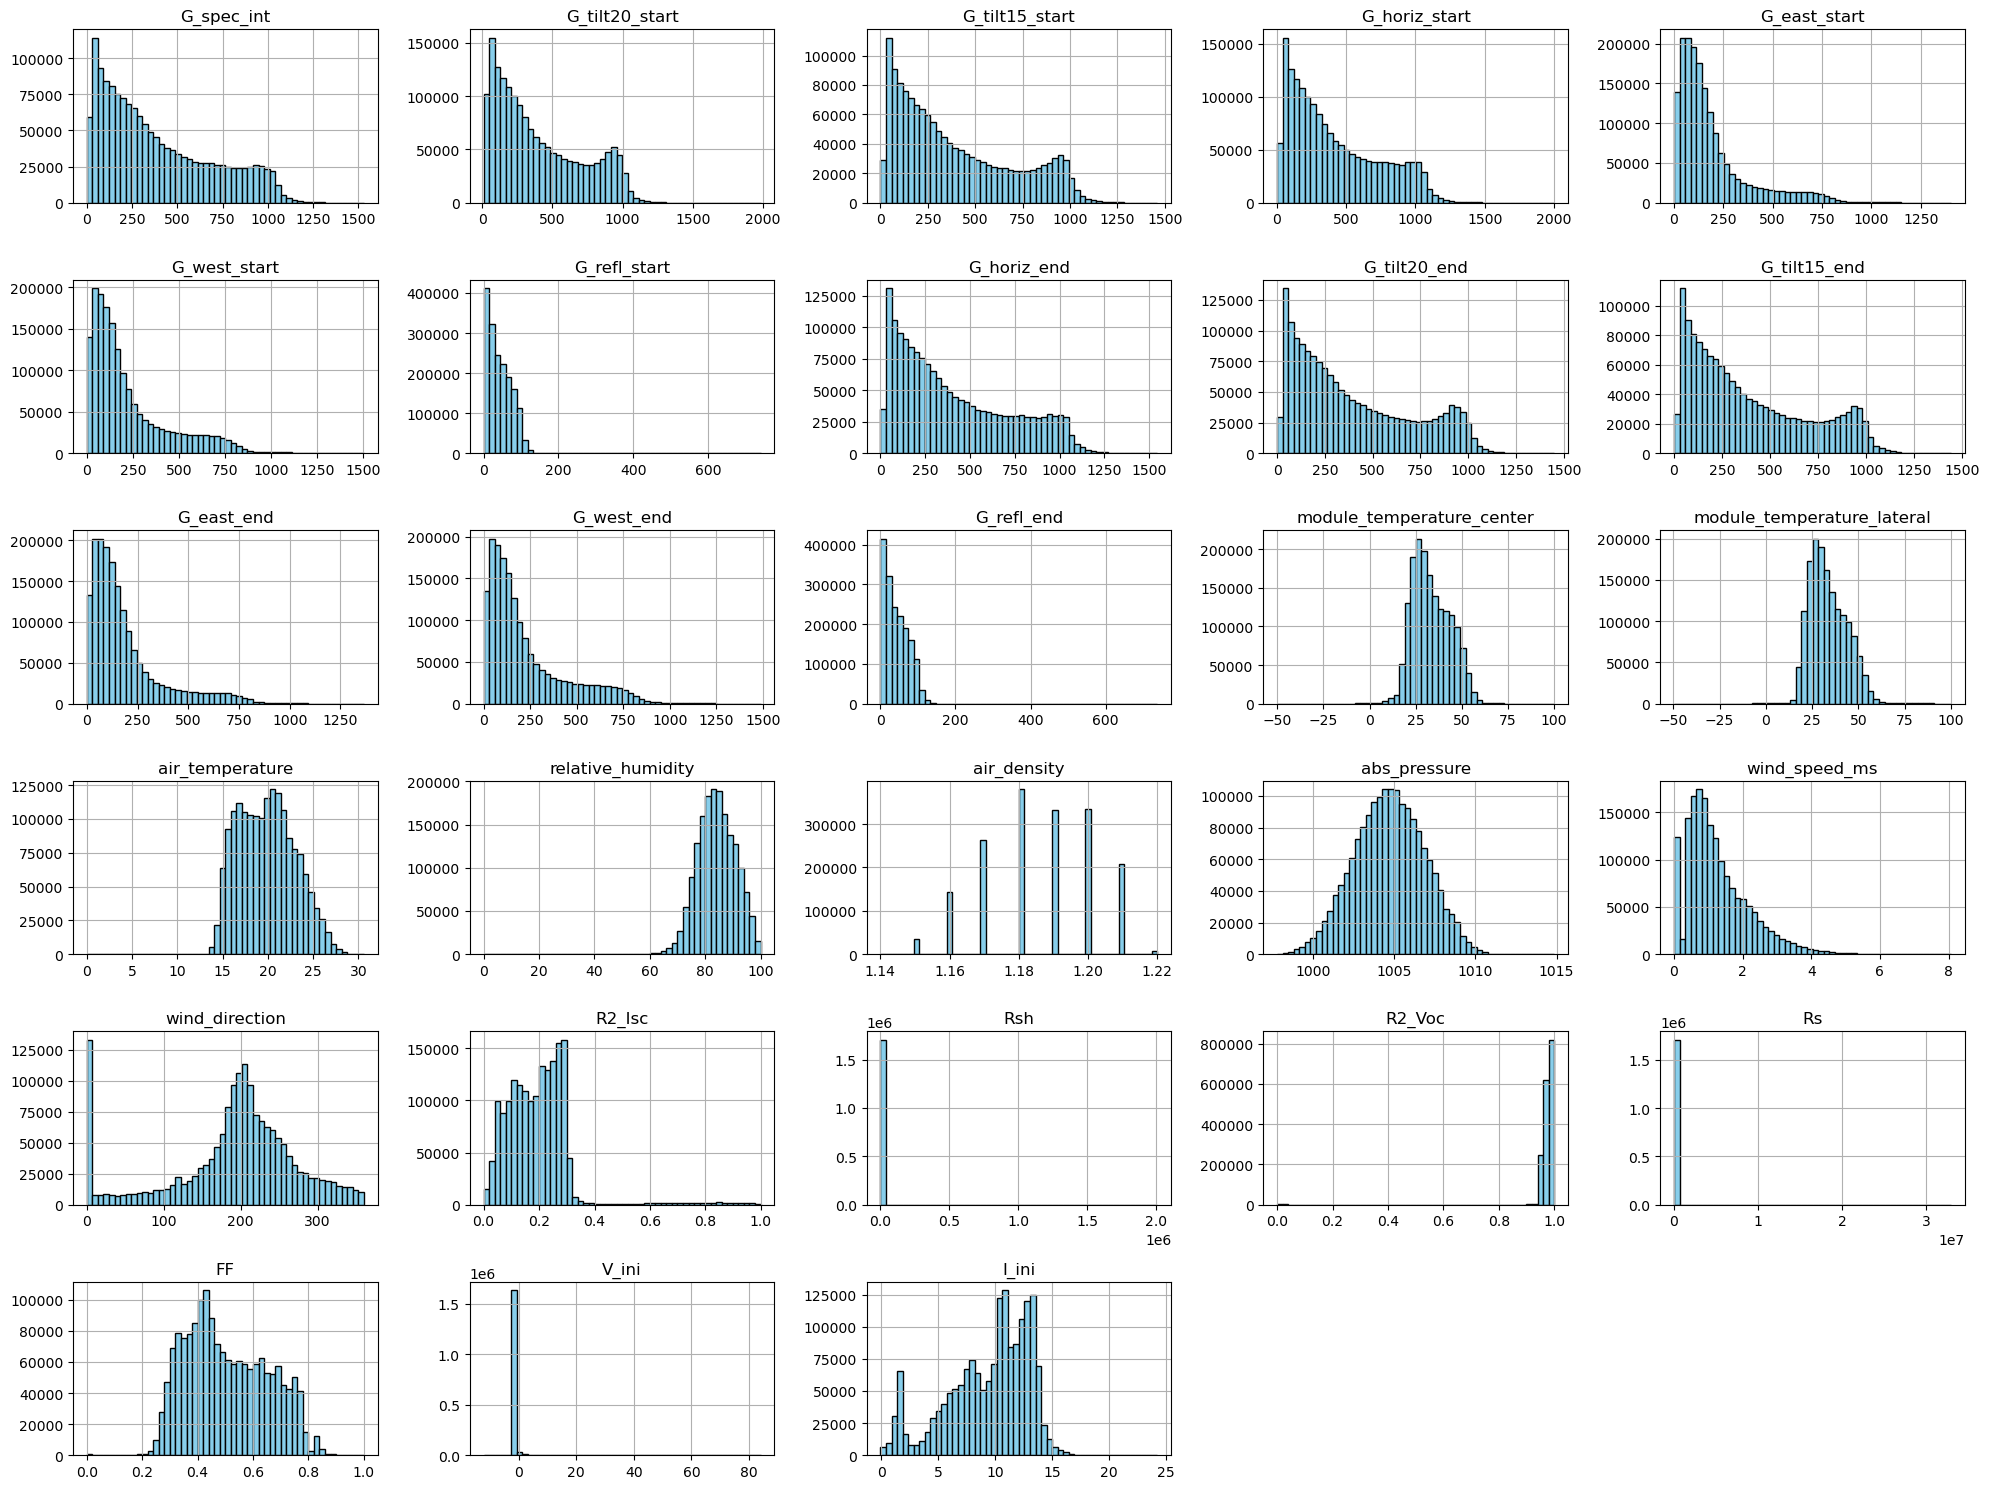

In [20]:
# Plot all numeric columns
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

## Statistics-based filtering

### Applying IQR filtering to normal-distributed variables

In [21]:
normal_looking = ['module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure']

df_normal = df_ambient[normal_looking]

In [22]:
def clean_by_iqr(df, multiplier=3.0):
    clean_df = df.copy()
    
    for col in clean_df.columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Replace outliers with NaN
        clean_df.loc[(clean_df[col] < lower_bound) | (clean_df[col] > upper_bound), col] = np.nan
        
    return clean_df
    
df_normal_cleaned = clean_by_iqr(df_normal, multiplier=1.5) 

In [23]:
summarize_cleaning(df_ambient[normal_looking], df_normal_cleaned)
# Update original df
df_ambient[normal_looking] = df_normal_cleaned

                             Before    After  Removed  % Removed
module_temperature_lateral  1548727  1541094     7633       0.49
relative_humidity           1708491  1703442     5049       0.30
module_temperature_center   1704222  1699523     4699       0.28
abs_pressure                1704418  1701842     2576       0.15
air_temperature             1708489  1707835      654       0.04
Summary: 20611 datapoints removed. 0.20% of total data.


## Transforming and applying IQR filter

Transforming irradiance and wind speed measurements to account for right skewdness before doing IQR filtering

In [24]:
def clean_skewed_outliers(df, multiplier=3.0):
    clean_df = df.copy()
    for col in clean_df.columns:
        # 1. Transform to log-space to normalize the "Right Skew"
        series_log = np.log1p(clean_df[col])
        
        # 2. Calculate IQR on the LOG-transformed data
        Q1 = series_log.quantile(0.25)
        Q3 = series_log.quantile(0.75)
        IQR = Q3 - Q1
        
        # 3. Define bounds in log-space
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        
        # 4. Create a mask of outliers
        # We do NOT drop them yet; we just identify their locations
        is_outlier = (series_log < lower) | (series_log > upper)
        
        # 5. Nullify the outliers in the ORIGINAL (untransformed) scale
        clean_df.loc[is_outlier, col] = np.nan
        
    return clean_df

# Now apply it
skewed_cols = [col for col in df_ambient.columns if col.startswith('G_')] + ['wind_speed_ms']
df_skewed_cleaned = clean_skewed_outliers(df_ambient[skewed_cols], multiplier=1.5)

In [25]:
summarize_cleaning(df_ambient[skewed_cols], df_skewed_cleaned)
# Re-attach to original
df_ambient[skewed_cols] = df_skewed_cleaned

                 Before    After  Removed  % Removed
G_spec_int      1537528  1499891    37637       2.45
wind_speed_ms   1708501  1704341     4160       0.24
G_east_end      1708501  1706646     1855       0.11
G_east_start    1708501  1706726     1775       0.10
G_west_start    1708501  1707716      785       0.05
G_west_end      1708501  1707732      769       0.05
G_horiz_end     1708500  1707988      512       0.03
G_tilt15_start  1439431  1439030      401       0.03
G_tilt15_end    1439434  1439044      390       0.03
G_tilt20_end    1708501  1708135      366       0.02
G_refl_end      1708501  1708307      194       0.01
G_refl_start    1708500  1708315      185       0.01
G_horiz_start   1708157  1708105       52       0.00
G_tilt20_start  1708489  1708488        1       0.00
Summary: 49082 datapoints removed. 0.21% of total data.


In [26]:
df_ambient.describe().T

,count,mean,std,min,25%,50%,75%,max
G_spec_int,1499891.0,398.173618,299.162026,1.345134e+01,145.604483,313.914221,615.306843,1.529526e+03
G_tilt20_start,1708488.0,401.489565,302.665194,2.322000e+01,143.050000,312.120000,630.262500,1.982440e+03
G_tilt15_start,1439030.0,390.242248,300.715799,1.315000e+01,134.660000,301.090000,611.490000,1.460320e+03
G_horiz_start,1708105.0,421.101911,315.166525,1.672000e+01,153.590000,331.070000,654.510000,1.999560e+03
G_east_start,1706726.0,187.938165,180.518042,9.950000e+00,67.280000,128.720000,229.500000,1.402550e+03
G_west_start,1707716.0,228.454681,214.837375,7.980000e+00,74.280000,148.690000,309.330000,1.502250e+03
G_refl_start,1708315.0,42.273231,30.328192,1.080000e+00,15.420000,36.540000,64.290000,3.625300e+02
G_horiz_end,1707988.0,409.265563,310.200797,1.495000e+01,145.460000,320.850000,640.560000,1.544920e+03
G_tilt20_end,1708135.0,394.834336,302.379522,1.321000e+01,136.570000,305.460000,623.650000,1.450160e+03
G_tilt15_end,1439044.0,390.347798,300.696740,1.314000e+01,134.760000,301.190000,611.680000,1.444120e+03


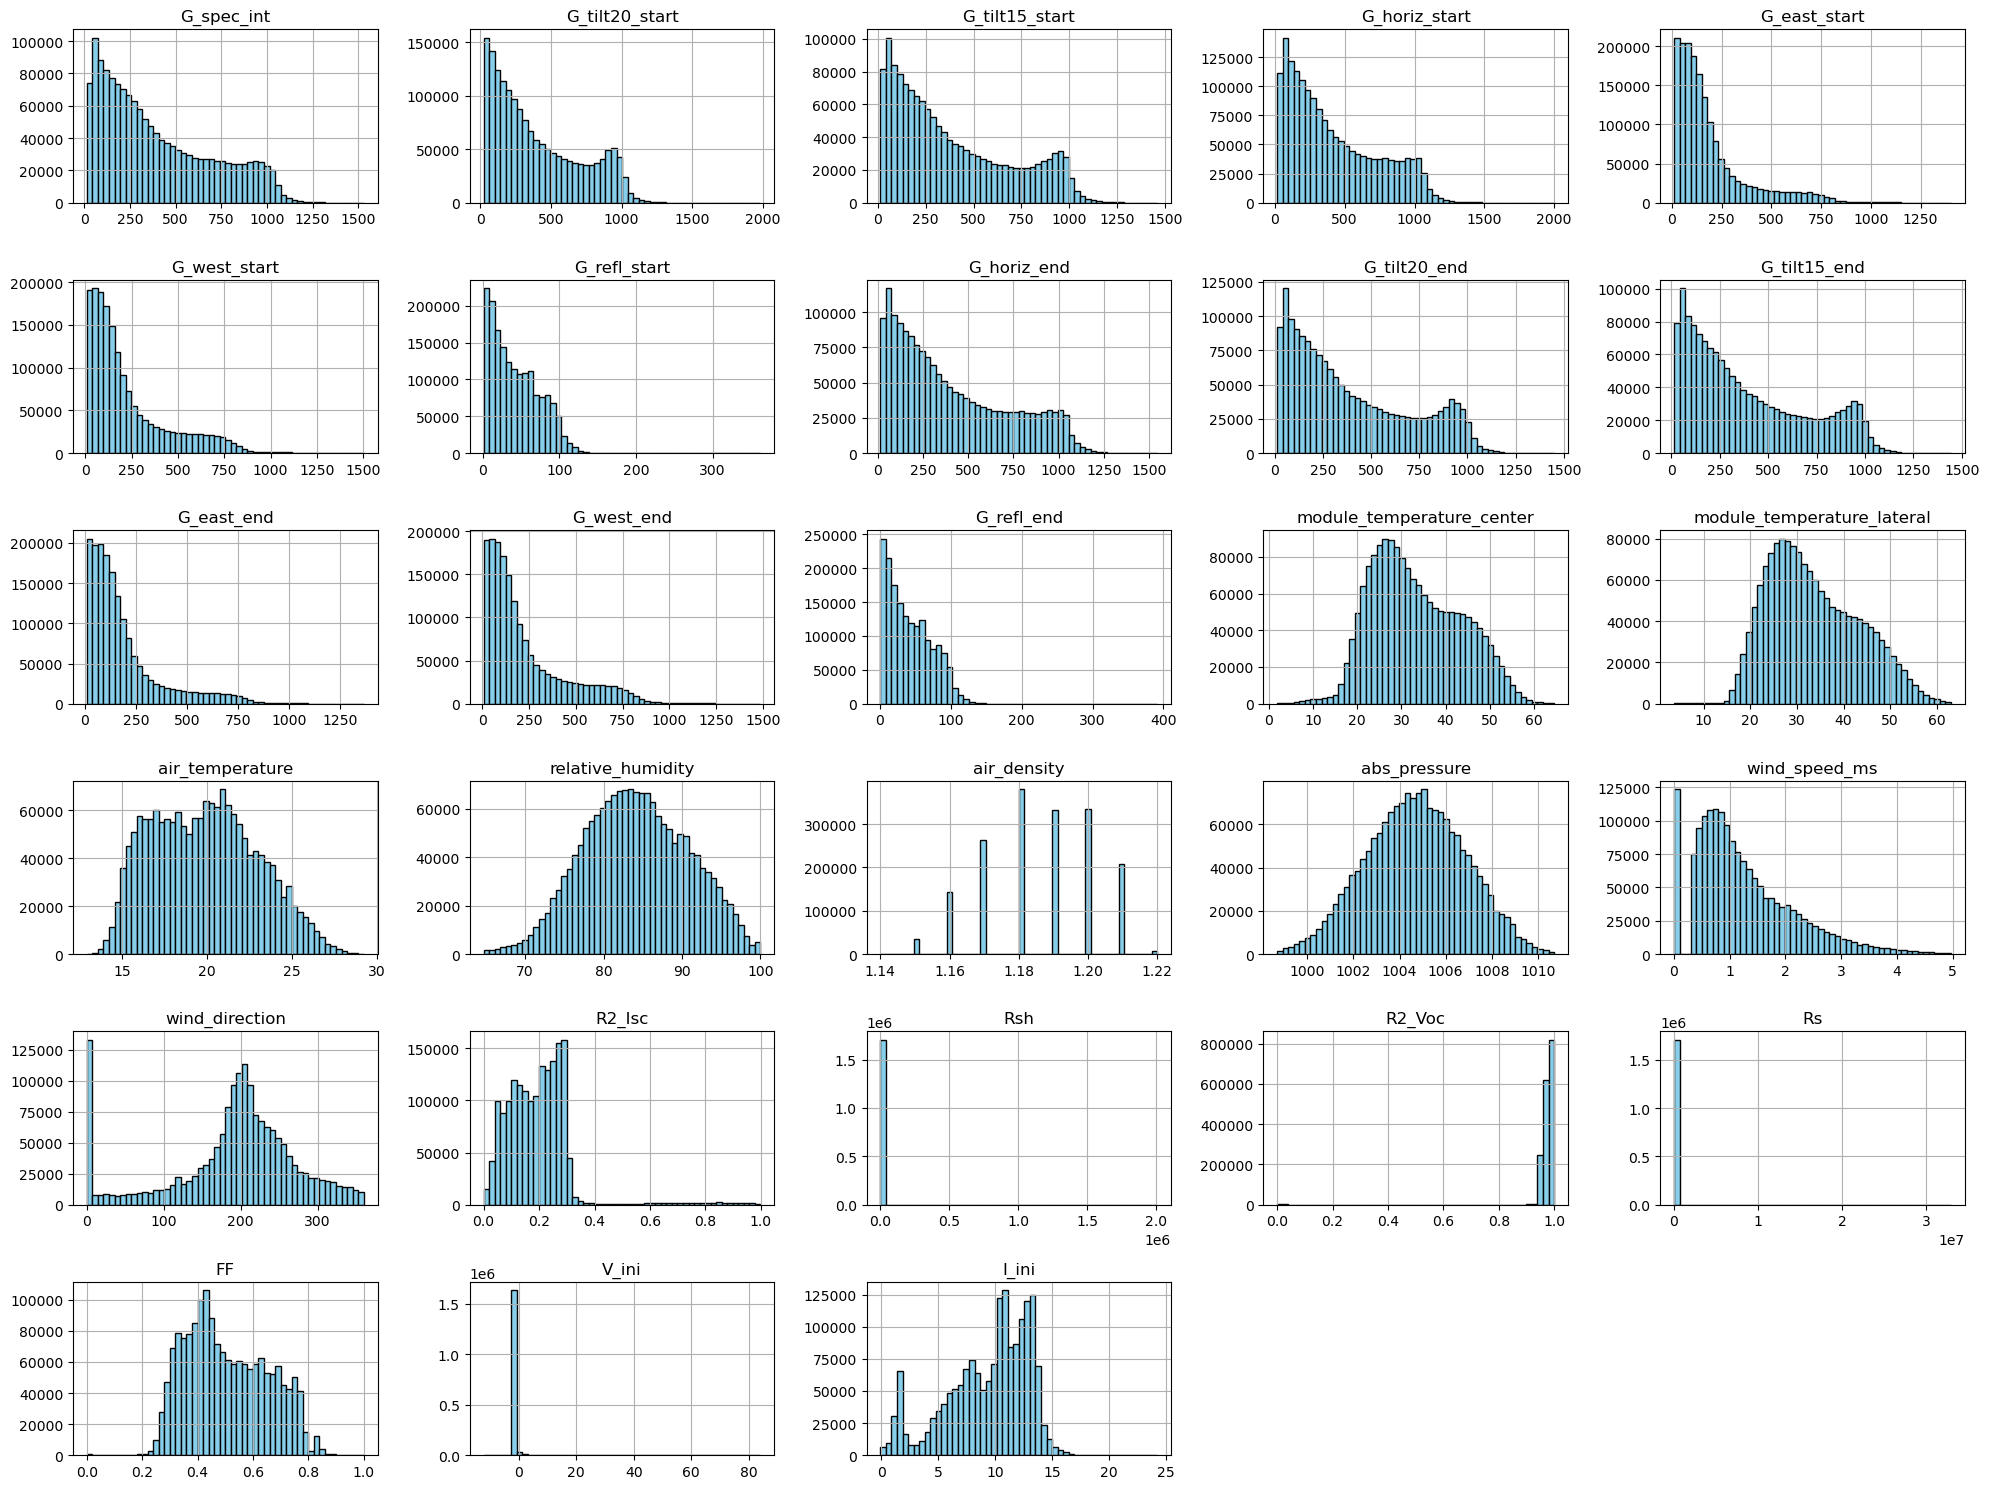

In [27]:
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

## Reattaching 

In [28]:
# Overwrite the columns in the main physics DataFrame with the cleaned ambient data
df_physics[df_ambient.columns] = df_ambient

In [29]:
summarize_cleaning(df, df_physics)

                             Before    After  Removed  % Removed
module_temperature_lateral  1708501  1541094   167407       9.80
G_spec_int                  1616184  1499891   116293       7.20
module_temperature_center   1708501  1699523     8978       0.53
abs_pressure                1708501  1701842     6659       0.39
Pmpp                        1708501  1703002     5499       0.32
relative_humidity           1708501  1703442     5059       0.30
Impp                        1708501  1703645     4856       0.28
wind_speed_ms               1708501  1704341     4160       0.24
FF                          1708094  1705410     2684       0.16
G_east_end                  1708501  1706646     1855       0.11
G_east_start                1708501  1706726     1775       0.10
air_density                 1708501  1706849     1652       0.10
Vmpp                        1708501  1706930     1571       0.09
G_west_start                1708501  1707716      785       0.05
G_west_end               

In [30]:
df_final = df_physics.reset_index(drop=True)

In [33]:
df_final.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,1708501,2024-01-04 04:18:24.911891712,2022-01-01 06:30:01,2023-01-06 14:55:19,2024-01-09 11:38:06,2024-12-29 12:35:19,2025-12-31 15:05:01,NaN
Vmpp,1706930.0,40.127346,0.0,31.743343,33.711664,53.316545,84.053757,11.18882
Impp,1703645.0,2.522225,0.0,0.60871,1.622859,3.745148,16.518959,2.454742
Pmpp,1703002.0,89.375763,0.00004,25.790745,63.338383,131.261594,4638.937488,81.651643
G_spec_int,1499891.0,398.173618,13.451335,145.604483,313.914221,615.306843,1529.526324,299.162026
G_tilt20_start,1708488.0,401.489565,23.22,143.05,312.12,630.2625,1982.44,302.665194
G_tilt15_start,1439030.0,390.242248,13.15,134.66,301.09,611.49,1460.32,300.715799
G_horiz_start,1708105.0,421.101911,16.72,153.59,331.07,654.51,1999.56,315.166525
G_east_start,1706726.0,187.938165,9.95,67.28,128.72,229.5,1402.55,180.518042
G_west_start,1707716.0,228.454681,7.98,74.28,148.69,309.33,1502.25,214.837375


In [31]:
df_final.head(10)

,filename,module_name,timestamp,Vmpp,Impp,Pmpp,G_spec_int,G_tilt20_start,G_tilt15_start,G_horiz_start,G_east_start,G_west_start,G_refl_start,G_horiz_end,G_tilt20_end,G_tilt15_end,G_east_end,G_west_end,G_refl_end,module_temperature_center,module_temperature_lateral,air_temperature,relative_humidity,air_density,abs_pressure,wind_speed_ms,wind_direction,Isc,R2_Isc,Rsh,Voc,R2_Voc,Rs,FF,V_ini,I_ini
0,VBHN330_01_01_2022_06_30_01.csv,VBHN330,2022-01-01 06:30:01,44.721021,0.113265,5.065330,23.218863,26.28,NaN,27.32,11.37,11.25,3.20,22.22,22.13,NaN,11.40,11.28,3.19,21.17,20.38,19.17,95.08,1.19,1003.87,0.53,317.01,0.307710,0.040858,36.111069,215.459507,0.857445,1506.503102,0.076401,-2.077111,8.303975
1,NAF128GK_01_01_2022_06_30_37.csv,NAF128GK,2022-01-01 06:30:37,36.339943,0.058908,2.140718,23.935465,26.01,NaN,26.95,11.67,11.55,3.36,23.26,22.82,NaN,11.88,11.65,3.42,20.87,20.09,19.19,95.05,1.19,1003.95,1.35,40.54,0.107974,0.028800,191.061792,47.480906,0.988244,104.088283,0.417562,-0.832341,1.469773
2,QPEAK315_01_01_2022_06_31_16.csv,QPEAK315,2022-01-01 06:31:16,29.964212,0.195919,5.870553,24.598475,25.89,NaN,26.89,11.92,11.75,3.42,23.73,23.16,NaN,12.00,11.71,3.51,20.37,20.05,19.19,95.05,1.19,1003.95,0.59,339.69,0.420008,0.078319,26.414298,34.860217,0.958309,15.247258,0.400951,-1.276841,4.394951
3,LG370Q1C_01_01_2022_06_31_35.csv,LG370Q1C,2022-01-01 06:31:35,29.967451,0.185282,5.552421,24.860619,26.28,NaN,27.38,12.09,11.79,3.54,24.18,23.64,NaN,12.06,11.83,3.51,22.06,20.67,19.26,95.17,1.19,1003.89,0.46,320.94,0.463826,0.082301,24.364856,36.688569,0.962679,19.248764,0.326285,-1.297689,4.787510
4,LG345N1C_01_01_2022_06_31_53.csv,LG345N1C,2022-01-01 06:31:53,30.807138,0.216801,6.679021,25.067576,26.53,NaN,27.65,12.18,11.91,3.55,24.30,23.71,NaN,12.22,11.88,3.48,20.88,NaN,19.26,95.17,1.19,1003.89,0.64,321.56,0.504668,0.079955,20.283403,36.065147,0.958082,14.490173,0.366960,-1.317866,5.724658
5,GSA060_01_01_2022_06_32_11.csv,GSA060,2022-01-01 06:32:11,53.182745,0.021837,1.161330,25.219610,28.28,NaN,28.94,12.24,11.96,3.50,24.37,24.33,NaN,12.43,12.00,3.45,21.05,20.89,19.26,95.17,1.19,1003.89,1.05,328.21,0.037147,0.012805,1138.775903,86.083433,0.991089,1423.275737,0.363180,-0.862577,0.839067
6,CDF1150A1_01_01_2022_06_33_11.csv,CDF1150A1,2022-01-01 06:33:11,35.898239,0.033540,1.204033,25.420068,27.79,NaN,28.94,12.50,12.06,3.54,24.65,24.31,NaN,12.60,12.16,3.51,21.18,20.86,19.23,94.94,1.19,1003.98,0.36,332.39,0.062639,0.028300,532.863587,54.374985,0.992835,324.940730,0.353503,-0.842571,0.766343
7,CS3K320MB-V_01_01_2022_06_34_11.csv,CS3K320MB-V,2022-01-01 06:34:11,30.133344,0.166733,5.024218,25.397348,26.75,NaN,27.83,12.62,12.27,3.60,24.46,23.97,NaN,12.60,12.24,3.63,25.27,25.17,19.19,94.93,1.19,1004.00,0.75,320.42,0.360273,0.094425,29.617558,34.474057,0.957630,17.475601,0.404525,-1.272395,3.303721
8,CS3K320MB-T_01_01_2022_06_34_29.csv,CS3K320MB-T,2022-01-01 06:34:29,29.823086,0.225905,6.737197,25.459511,26.88,NaN,28.16,12.63,12.17,3.59,24.71,24.08,NaN,12.63,12.24,3.69,26.17,26.05,19.16,94.98,1.19,1003.94,0.46,322.99,0.468164,0.114812,23.721779,34.988854,0.958861,13.483851,0.411293,-1.245545,3.350677
9,VBHN330_01_01_2022_06_35_01.csv,VBHN330,2022-01-01 06:35:01,49.466199,0.118800,5.876607,25.655074,29.25,NaN,30.23,12.74,12.41,3.70,24.44,24.38,NaN,12.74,12.38,3.62,21.24,20.49,19.16,94.98,1.19,1003.94,0.00,0.00,0.201049,0.044728,112.792796,110.913273,0.974991,519.348153,0.263535,-1.684439,2.662584


In [6]:
df_final.columns

Index(['filename', 'module_name', 'timestamp', 'Vmpp', 'Impp', 'Pmpp',
       'G_spec_int', 'G_tilt20_start', 'G_tilt15_start', 'G_horiz_start',
       'G_east_start', 'G_west_start', 'G_refl_start', 'G_horiz_end',
       'G_tilt20_end', 'G_tilt15_end', 'G_east_end', 'G_west_end',
       'G_refl_end', 'module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure',
       'wind_speed_ms', 'wind_direction', 'Isc', 'R2_Isc', 'Rsh', 'Voc',
       'R2_Voc', 'Rs', 'FF', 'V_ini', 'I_ini'],
      dtype='object')

In [7]:
df_final.drop('filename', axis=1, inplace=True)
df_final.to_csv("PV_dataset.csv", index=False)

# Module metadata

In [29]:
df_final = pd.read_csv("PV_dataset.csv")
modules = df_final["module_name"].value_counts()
modules

module_name
CDF1150A1       174105
VBHN330         173922
QPEAK315        173238
LG345N1C        172862
LG370Q1C        172686
CS6K270P        168412
GSA060          151346
NAF128GK        146819
CS3K320MB-T     116174
CS3K320MB-V     112459
CIEH5C1325-V     49940
CIEH5C1325-T     35731
CHSM78N630       20536
CHSM78N630-V     18365
CHSM78N630-T      7722
TSMDEG405-r       3699
TSMDEG405-f       3699
CS3K320MB-r       2765
CS3K320MB-f       2763
CIEH5C1325        1258
Name: count, dtype: int64